# Human Genome Language Model
1. Initialisation
    - 1.1 Imports
    - 1.2 Data processing
2. Tokenisation
    - 2.1 Fixed Length Tokenisation
    - 2.2 Variable Length Tokenisation
3. Experiments
    - 3.1 Comparing fixed and variable length tokenisation strategies

---
# 1. Initialisation
## 1.1 Imports and config
Libraries used include:
- `fastai` for access to the ULMFiT model API
- `pandas` and `matplotlib` for data science toolset

Handy tricks include:
- `autoreload` functionality so that updates to library code are automatically recompiled any time a cell is run.
- `InteractiveShell` is used for multiple outputs from a single cell.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from fastai import *
from fastai.text import *
import sentencepiece as spm
import pandas as pd, matplotlib.pyplot as plt
import numpy as np
# import cupy as np

# Imports from GenomicULMFiT repo
sys.path.append("../../../Genomic-ULMFiT/")
sys.path.append("../..")

from src.processing import process_fasta
from src.config import GRCH38_P13, GENOME
from utils import *

In [4]:
HOME_LOCAL  = '/home/jovyan/ml_genomics'
HOME_REMOTE = '/home/athon/'

HOME        = HOME_REMOTE

THESIS      = HOME / Path('thesis/')
HUMAN       = THESIS / Path('data/human/')

In [5]:
# Dataset params
NROWS_TRAIN     = 20000
NROWS_VAL       = 20000
BATCH_SIZE      = 100

# Tokenisation - fixed
NGRAM_STRIDE    = [(3,1),(5,1),(7,1)]  #(ngram,stride) combinations for tokenisation

# Tokenisation - variable
MAX_VOCAB       = [4**3, 4**5, 4**7]

## 1.2 Data Initialisation
This process assumes data has already been read and processed into `.csv` format via the `process_fasta` script.
Data is read from `human_genome_data_fa.csv` in chunks to reduce data in memory. This can then be iterated with `df.next()`.

In [6]:
df_iter = pd.read_csv(HUMAN/'human_genome_data_fa.csv', chunksize=NROWS_TRAIN+NROWS_VAL)
df = next(df_iter)

# set val to be first 20k rows
df_tr = df[:NROWS_TRAIN]
df_va = df[NROWS_TRAIN:NROWS_TRAIN+NROWS_VAL]

In [7]:
df_tr

,Sequence,Source
0,TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC...,NCBI Human
1,CATCTGCAGGTGTCTGACTTCCAGCAACTGCTGGCCTGTGCCAGGG...,NCBI Human
2,ACCTGCCCCACAGCCTTGCCTGGATTTCTATCTCCCTGGCTTGGTG...,NCBI Human
3,CTGGGGAAGCTTACTGTGTCCAAGAGCCTGCTGGGAGGGAAGTCAC...,NCBI Human
4,TGAAGATGGAGCCATATTCCTGCAGGCGCCCTGGAGCAGGGTACTT...,NCBI Human
5,CCTGGTGCTCCCACAAAGGAGAAGGGCTGATCACTCAAAGTTGCGA...,NCBI Human
6,TTCCCTTGGGGAATCCATCTCTCTCGCAGGCTTAGTCCCAGAGCTT...,NCBI Human
7,GCCAGGCTTCCCATGACGAGCCTCACAGTACCCCATCTCCCCTGAA...,NCBI Human
8,TATTTTACATAACGCACCACACCAACATCTTCACCCAGTTGGAGCC...,NCBI Human
9,ATATGTTTTGTTGTTTTCATGCAATAATGCAAATCTTAGCCCAAAC...,NCBI Human


---
# 2. Tokenisation
## 2.1 Fixed length tokenisation
- Technique of original author was to iterate over entire genome sequence with for loops.
- We need to vectorise this.

In [211]:
data = np.array([['a','b','c'],['c','d','e']])
[d.astype('|S1').tostring().decode('utf-8') for d in data]

['abc', 'cde']

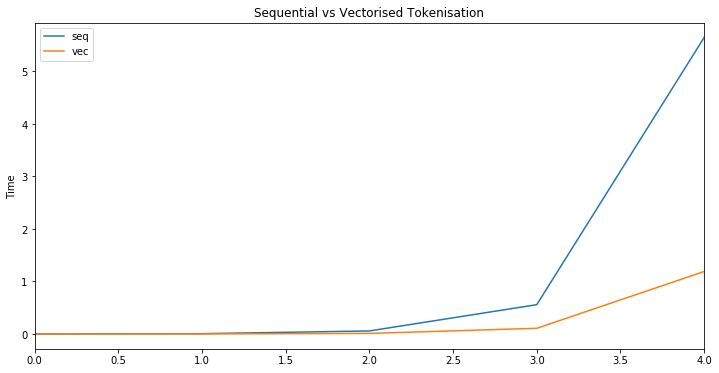

In [207]:
# from tools.tokenizers import seq_tokenizer, vec_tokenizer

def seq_tokenizer(t, ngram, stride):
    import time
    t = t.upper()
    if ngram == 1:
        toks = list(t)
    else:
        start = time.time()
        toks = [t[i:i+ngram] for i in range(0, len(t), stride) if len(t[i:i+ngram]) == ngram]

    if len(toks[-1]) < ngram:
        toks = toks[:-1]

    return toks,time.time() - start

def vec_tokenizer(a, ngram, stride):
    import numpy as np; import time
    
    def my_func(a):
        return (a[0] + a[1] + a[2])
    
    start = time.time()
    a = np.array(list(a))
    shape = ((a.size - ngram)//stride + 1, ngram)
    strides = (a.itemsize*stride, a.itemsize)
    data = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    return data, time.time() - start

# Test how well the vectorisation works
def test_tokenizers():
    seq_=[]; vec_=[]
    for i in [1,10,100,1000,10000]:
        test = ''.join([''.join(row) for row in df.head(i).values[:,0]])
        toks ,time  = seq_tokenizer(test, 3, 1);seq_.append(time)
        toks_,time_ = vec_tokenizer(test, 3, 1);vec_.append(time_)
    
    fig,ax = plt.subplots(figsize=(12,6))

    stats=pd.DataFrame({'seq':seq_,'vec':vec_})
    stats.plot(ax=ax)
    ax.set_title('Sequential vs Vectorised Tokenisation')
    ax.set_ylabel('Time')
    
test_tokenizers()

### Vectorised technique for faster fixed Length tokenisation

In [212]:
import time

class FixedLengthGenomicTokenizer(BaseTokenizer):
    """
    Fixed length tokenisation for DNA.
    """
    def __init__(self, lang='en', ngram=5, stride=2):
        self.lang = lang
        self.ngram = ngram
        self.stride = stride
        
    def tokenizer(self, t):
        t = t.upper()
        if self.ngram == 1:
            toks = list(t)
        else:
            toks = [t[i:i+self.ngram] for i in range(0, len(t), self.stride) if len(t[i:i+self.ngram]) == self.ngram]
        if len(toks[-1]) < self.ngram:
            toks = toks[:-1]
        return toks
    
    def add_special_cases(self, toks):
        pass
    

In [213]:
%%time
def generate_fixed_vocab(df_train, df_val, ngram=3, stride=1):
    """Create fixed length tokenizer, initialise databunch and return vocabulary."""
    
    # initialise tokeniser
    tok = Tokenizer(partial(GenomicTokenizer, ngram=ngram, stride=stride), 
                    n_cpus=96,
                    pre_rules=[],
                    post_rules=[],
                    special_cases=[])
    
    data = GenomicTextLMDataBunch.from_df(HUMAN, df_train, df_val, bs=BATCH_SIZE, tokenizer=tok, 
                              chunksize=NROWS_TRAIN, text_cols=0, label_cols=1, max_vocab=((4**ngram)+1))

    # Save and load vocab
    np.save(HUMAN / 'fixed_vocab_{}m{}s.npy'.format(ngram,stride), data.vocab.itos)
    return data.vocab.itos
    
vocabs = []
for ngram_stride in NGRAM_STRIDE:
    vocabs.append(generate_fixed_vocab(df_tr, df_va, *ngram_stride))

CPU times: user 1min 19s, sys: 35.2 s, total: 1min 54s
Wall time: 2min


In [214]:
%%time
def generate_variable_vocab(df_train, df_val, size=128):
    """Create variable length vocabulary using SentencePiece tokenisation.
    """
    spm = 'spm_{}_rows_{}_tok'.format(df_tr.shape[0], size)
    if os.path.exists(HUMAN/spm): # load cached SP model and use for tokenisation
        SPM = HUMAN/spm
        sp_proc = SPProcessor(char_coverage=1, 
                              vocab_sz=size,
                              n_cpus = 96,
                              pre_rules=[],
                              post_rules=[],
                              sp_model=SPM/'spm.model',
                              sp_vocab=SPM/'spm.vocab')
    else: # train model and save at that directory
        sp_proc = SPProcessor(char_coverage=1, 
                              vocab_sz=size,
                              n_cpus = 96,
                              pre_rules=[],
                              post_rules=[],
                              tmp_dir=spm)
    
    data = GenomicTextLMDataBunch.from_df(
        HUMAN, df_train, df_val, bs=BATCH_SIZE, processor=sp_proc,
        chunksize=NROWS_TRAIN, text_cols=0, label_cols=1, max_vocab=size
    )
    
    # Save and load vocab
    np.save(HUMAN / 'variable_vocab_{}tok.npy'.format(size), data.vocab.itos)
    return data.vocab.itos
    
for max_vocab in MAX_VOCAB:
    vocabs.append(generate_variable_vocab(df_tr, df_va, size=max_vocab))

CPU times: user 11h 35min 52s, sys: 29.6 s, total: 11h 36min 22s
Wall time: 48min 7s


---

# Experimental Setup
We propose to explore model performance across different fixed and variable token parameters.
For fixed length tokenisation, the parameters of interest are the number of base pairs per token, also known as `ngram`.
Additionally, the number of base pairs between the start of 1 token and the next is known as `stride`. As an example, take the sequence of base pairs:
$$\text{TCTGGCGACAACCAGGGA}$$

Using fixed length tokenisations of size **_3_** and stride **_0_**, we have the following outputs:
$$\text{[TCT],[GGC],[GAC],[AAC],[CAG],[GGA]}$$

For parameters: `{size:3, stride:1}`
$$\text{[TCT],[],[],[GGC],[],[],[GAC],[],[],[AAC],[],[],[CAG],[],[],[GGA]}$$

For parameters: `{size:5, stride:3}`
$$\text{[TCT],[GGC],[GAC],[AAC],[CAG],[GGA]}$$

For parameters: `{size:7, stride:5}`
$$\text{[TCT],[GGC],[GAC],[AAC],[CAG],[GGA]}$$


## Incorporating colour

In [215]:
from IPython.display import HTML as html_print
from pylab import *

def printc(s, color='white'):
    display(html_print("<text style=color:{}>{}</text>".format(color, s)))

def colour_gradient(n):
    cmap = cm.get_cmap('viridis', n)    # PiYG

    hexcol = []
    for i in range(cmap.N):
        rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
        c_hex = matplotlib.colors.rgb2hex(rgb)
        printc('test', str(c_hex))
        
def construct_html(wordlist, newline=50):
    html=""
    for i,pair in enumerate(wordlist):
        if (i!=0 and i%newline == 0):
            display(html_print(html))
            html=""
        html = html + "<text style=font-family:monospace;color:{1}>{0}</text>".format(*pair)
    display(html_print(html))

def hexcols(n=100):
    cmap = cm.get_cmap('viridis', n)
    return [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

# variable length tokenised data
i = 10; test = ''.join([''.join(row) for row in df.head(i).values[:,0]])
test = test[:1600]
construct_html([x for x in zip(test,hexcols(len(test)))], newline=80)

In [218]:
from utils import generate_variable_vocab
test_sp, vocab = generate_variable_vocab(df_tr, df_va, 16384)

In [219]:
tok_str = ''.join([str(test_sp.x[i]) for i in range(len(test_sp.x))])
tokens  = [tok for tok in tok_str.split(' ') if set(tok) <= set('ACTG')]

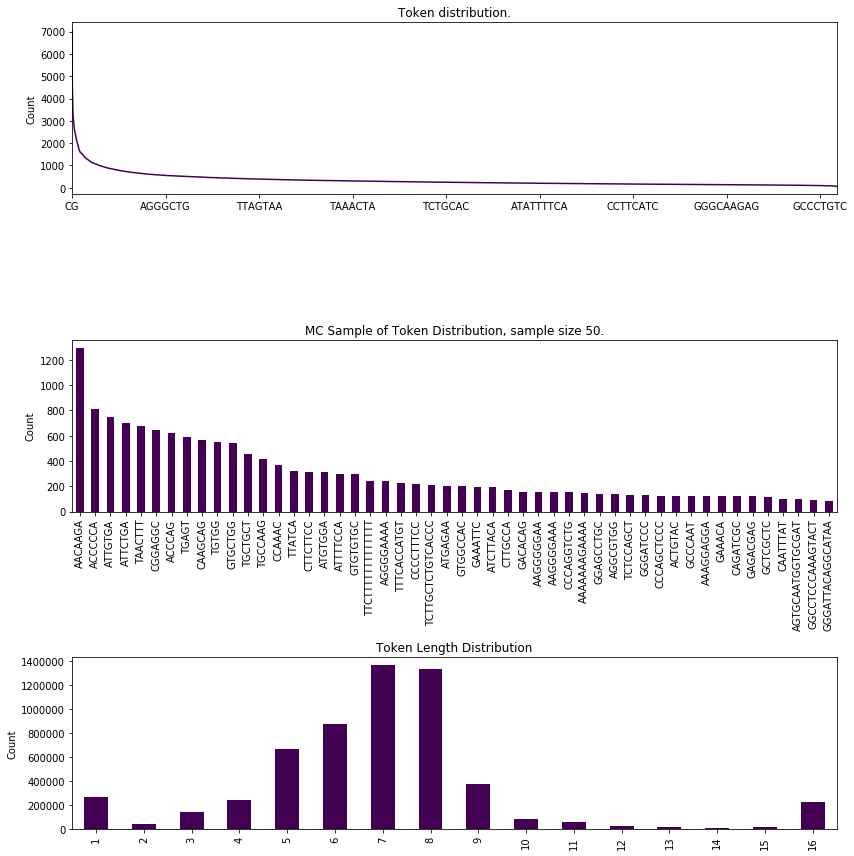

In [220]:
def plot_tok_dist(tokens, sample=50):
    fig, axs = plt.subplots(nrows=3, figsize=(12,12))
    
    pd.Series(tokens).value_counts().tail(-1).plot(ax=axs[0],cmap='viridis')
    axs[0].set_title('Token distribution.'.format(sample))
    axs[0].set_ylabel('Count')
    
    pd.Series(tokens)\
        .value_counts().tail(-1).sample(sample).sort_values(ascending=False).plot.bar(ax=axs[1], cmap='viridis')
    axs[1].set_title('MC Sample of Token Distribution, sample size {}.'.format(sample))
    axs[1].set_ylabel('Count')
    
    pd.Series([len(token) for token in tokens])\
        .value_counts().sort_index().plot.bar(ax=axs[2], cmap='viridis')
    axs[2].set_title('Token Length Distribution')
    axs[2].set_ylabel('Count')
    
    plt.tight_layout()
    
plot_tok_dist(tokens)

## Colouring Bases

In [282]:
# pd.Series(tokens).value_counts().tail(-1)
def vis_tokens(toks=tokens[-1000:], by='length', trim=1):
    
    if by == 'length':
        ys = [len(token) for token in toks]
    
    elif by == 'likelihood':
        counts = pd.Series(tokens).value_counts()
        ys = [counts[str(token)] if token not in counts.index[0:trim]\
              else counts.values[trim] for token in toks]
        
    ymax = max(ys); ymin = min(ys)
    print(ymax,ymin)
    cmap = cm.get_cmap('viridis', ymax)

    hexs = [matplotlib.colors.rgb2hex(cmap(y)[:3]) for y in ys]
    construct_html([x for x in zip(toks,hexs)], newline=50)

### Colour by token length

In [283]:
vis_tokens(by='length')

16 1


### Colour by token likelihood

In [287]:
vis_tokens(by='likelihood', trim=10)

3785 97


---